# Condition Robustness
We want to analyse the robustness with the updated error bounds considering the supremum of the derivative.

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt

## Condition $\frac{\sigma_1}{\sigma_n}$

We consider the condition 
\begin{equation}
    k: S \rightarrow \mathbb{R}, k(A) = \frac{\sigma_1}{\sigma_n}
\end{equation}
where  $m\geq n, S=\{A\in\mathbb{R}^{m\times n}|A\text{ has full rank }n\}$. Because of the mean value theorem we now $|k({\tilde {A}})-k(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dk(A')\|_F $. This implies for $\sigma_n-\|E\|_F>0$
$$    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | 
    \leq \frac{\|E\|_F}{\sigma_n-\|E\|_F}\sqrt{ 1+\frac{\sigma_1+\|E\|_F}{\sigma_n-\|E\|_F}^2 }$$

This bound is only valid of $\sigma_n - \|E\|_F >0$ which might not be the case for $\sigma_n$  small.

In [2]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_condition(omax,omin,eps):
    if omin-eps>0:
        return eps/(omin-eps)*np.sqrt(1+((omax+eps)/(omin-eps))**2)
    else:
        return np.infty

In [15]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[0]/sv[-1]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.039210557127285495
[[-6.06197967e-02 -3.73401960e+00 -1.54600702e+00]
 [-1.46553389e-01 -4.84085474e+00 -3.73760026e+00]
 [-1.90843176e-01 -2.68004073e+00 -4.86713757e+00]
 [-1.12530860e-01  8.42856215e-02 -2.86991229e+00]
 [-1.46415089e-01 -2.25901977e-01 -3.73407317e+00]
 [-8.64739610e-02 -4.45075654e+00 -2.20537445e+00]
 [ 4.73046780e-03 -2.58659147e+00  1.20642708e-01]
 [ 2.16259250e-02 -1.10622266e+00  5.51533225e-01]
 [-1.61913923e-01 -1.51720583e-01 -4.12934512e+00]
 [ 2.14298233e-02  1.21117065e-01  5.46531978e-01]]


In [17]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [1.12330998e+01 5.57562136e+00 1.04548180e-16] 	 1.074e+17  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [1.12330998e+01 5.57562136e+00 6.60959262e-10] 	 1.700e+10  	 inf	 1.074e+17
 1e-09	 	 3 	 	 [1.12330998e+01 5.57562136e+00 3.79210922e-09] 	 2.962e+09  	 inf	 1.074e+17
 1e-08	 	 3 	 	 [1.12330997e+01 5.57562143e+00 6.34597952e-08] 	 1.770e+08  	 inf	 1.074e+17
 1e-07	 	 3 	 	 [1.12330994e+01 5.57562151e+00 7.88230022e-07] 	 1.425e+07  	 inf	 1.074e+17
 1e-06	 	 3 	 	 [1.12330975e+01 5.57562594e+00 6.07504006e-06] 	 1.849e+06  	 inf	 1.074e+17
 1e-05	 	 3 	 	 [1.12331133e+01 5.57559097e+00 4.97680944e-05] 	 2.257e+05  	 inf	 1.074e+17
 0.0001	 	 3 	 	 [1.12329545e+01 5.57584424e+00 6.92695842e-04] 	 1.622e+04  	 inf	 1.074e+17
 0.001	 	 3 	 	 [1.12371838e+01 5.57758148e+00 3.93612055e-03] 	 2.855e+03  	 inf	 1.074e+17
 0.01	 	 3 	 	 [11.24023294  5.56539046  0.04893999] 	 2.297e+02  	 inf	 1.074e+17
 0.1	 	 3 	 	

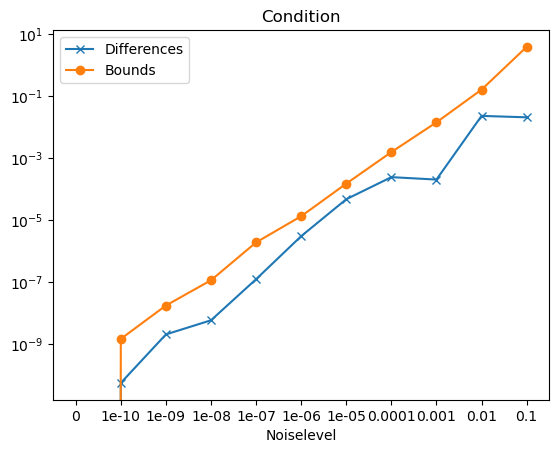

In [6]:
plt.title("Condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [18]:
trials=10
noise_level=1e-1
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t  ratio \t  bound \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}\t  {ratio:3.3e}   \t {bound:3.3e} \t  {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  0.1, Number trials: 10, True ratio: 1.0744424051364554e+17
Trial 	 matrix rank 	 sv 	 	 	 	 	  ratio 	  bound 	 difference
 0	 	 3 	 [11.18775506  5.25933972  0.68870087]	  1.624e+01   	 inf 	  1.074e+17
 1	 	 3 	 [10.94851418  5.69578044  0.6873217 ]	  1.593e+01   	 inf 	  1.074e+17
 2	 	 3 	 [11.17581212  5.39948031  0.50150041]	  2.228e+01   	 inf 	  1.074e+17
 3	 	 3 	 [11.22684326  5.31400516  0.73052633]	  1.537e+01   	 inf 	  1.074e+17
 4	 	 3 	 [11.48732331  5.18917536  0.44418208]	  2.586e+01   	 inf 	  1.074e+17
 5	 	 3 	 [11.37579704  5.893888    0.84574702]	  1.345e+01   	 inf 	  1.074e+17
 6	 	 3 	 [11.49164002  5.39143431  0.7577691 ]	  1.517e+01   	 inf 	  1.074e+17
 7	 	 3 	 [10.92032207  5.9334686   0.29873382]	  3.656e+01   	 inf 	  1.074e+17
 8	 	 3 	 [10.82214019  5.49639686  0.58372983]	  1.854e+01   	 inf 	  1.074e+17
 9	 	 3 	 [11.18132098  5.26147242  0.9662304 ]	  1.157e+01   	 inf 	  1.074e+17


## Reversed condition $\frac{\sigma_n}{\sigma_1}$

We consider the function reversed condition 
\begin{equation}
    r: \mathbb{R}^{m\times n} \rightarrow \mathbb{R}, r(A) = \frac{\sigma_n}{\sigma_r}
\end{equation}
where  $m\geq n$. Because of the mean value theorem we now $|r({\tilde {A}})-r(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dr(A')\|_F $. This implies for $\sigma_1-\|E\|_F>0$
$$    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | 
    \leq \frac{\|E\|_F}{\sigma_1-\|E\|_F}\sqrt{ 1+\frac{\sigma_n+\|E\|_F}{\sigma_1-\|E\|_F}^2 }$$

### Reversed condition: Error bounds

In [20]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_rev_condition(omax,omin,eps):
    assert(omax-eps>0)
    return eps/(omax-eps)*np.sqrt(1+((omin+eps)/(omax-eps))**2)


In [21]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.6148114365541958
[[-0.64947988 -4.21740643 -1.05638875]
 [-0.7816939  -1.87205522 -1.27143682]
 [-1.26482361 -3.60540095 -2.05725453]
 [-0.19858903 -0.88836978 -0.32300803]
 [-2.66422226  0.29860134 -4.33339737]
 [-2.65162762 -0.67658793 -4.312912  ]
 [-1.80996881 -0.87985749 -2.94394135]
 [-0.35204882 -2.18094567 -0.57261267]
 [-0.86374252 -1.37044768 -1.40489013]
 [-1.05006117  0.85460091 -1.7079402 ]]
matrix shape: (10, 3), rank: 2
Singular values : [9.60641575e+00 5.64500769e+00 6.33037995e-16]
Condtion big/smallest singular value: 6.589741807824772e-17
Bound: 0.0


In [26]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    bound=error_bound_rev_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_min/sv_max))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_min/sv_max):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [9.60641575e+00 5.64500769e+00 6.33037995e-16] 	 6.590e-17  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [9.60641576e+00 5.64500769e+00 4.75331710e-10] 	 4.948e-11  	 1.211e-10	 4.948e-11
 1e-09	 	 3 	 	 [9.60641575e+00 5.64500769e+00 4.36188721e-09] 	 4.541e-10  	 1.256e-09	 4.541e-10
 1e-08	 	 3 	 	 [9.60641575e+00 5.64500770e+00 8.79807261e-08] 	 9.159e-09  	 1.390e-08	 9.159e-09
 1e-07	 	 3 	 	 [9.60641558e+00 5.64500762e+00 6.87255917e-07] 	 7.154e-08  	 1.387e-07	 7.154e-08
 1e-06	 	 3 	 	 [9.60641566e+00 5.64500542e+00 4.66437400e-06] 	 4.855e-07  	 9.976e-07	 4.855e-07
 1e-05	 	 3 	 	 [9.60642908e+00 5.64501253e+00 6.54885965e-05] 	 6.817e-06  	 1.010e-05	 6.817e-06
 0.0001	 	 3 	 	 [9.60627703e+00 5.64506116e+00 4.83262423e-04] 	 5.031e-05  	 1.027e-04	 5.031e-05
 0.001	 	 3 	 	 [9.60697813e+00 5.64458639e+00 6.78803933e-03] 	 7.066e-04  	 1.270e-03	 7.066e-04
 0.01	 	 3 	 	 [9.61791318 5.63917557 0.03661961

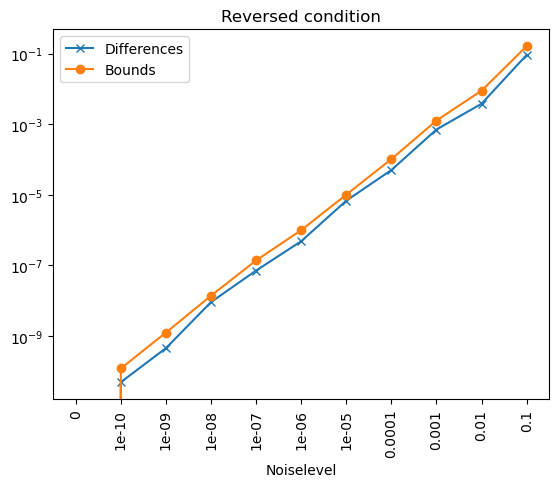

In [27]:
plt.title("Reversed condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed condition: Threshold

If a matrix $A$ is singular ($\sigma_n=0$) we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{\epsilon}{C-\epsilon}\sqrt{ 1+\frac{\epsilon}{C-\epsilon}^2 }$$
for $C\leq \sigma_1$ and $\epsilon \geq \|E\|_F$.
If a matrix $A$ is non singular ($\sigma_n>0$) we have
\begin{align} \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} 
&\geq \frac{\sigma_n}{\sigma_1} - \frac{\epsilon}{\sigma_1-\epsilon}\sqrt{ 1+\frac{\sigma_n+\epsilon}{\sigma_1-\epsilon}^2 }\\
&\geq \frac{C_2^l}{C_1^u} - \frac{\epsilon}{C_1^l-\epsilon}\sqrt{ 1+\frac{C_2^u +\epsilon}{C_1^l-\epsilon}^2 }
\end{align}
for $C_1^l\leq \sigma_1 \leq C_2^u, C_2^u \geq \sigma_n \geq C_2^l$.

In [126]:
def upper_bound_singular_matrix(C,eps):
    assert(C-eps>0)
    bound= eps/(C-eps)*np.sqrt(1+(eps/(C-eps))**2)
    return bound
def lower_bound_nonsingular_matrix(C1_up,C2_up, C1_low,C2_low,eps):
    assert(C1-eps>0)
    bound= C2_low/C1_up - eps/(C1_low-eps)*np.sqrt(1+((C2_up+eps)/(C1_low-eps))**2)
    return max(bound,1e-8)

In [127]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.800530877513467
[[-2.52795066 -3.97817076 -3.15784279]
 [-0.18304937 -1.1679856  -0.22865998]
 [ 0.12382471 -2.53797779  0.15467824]
 [-0.05230797 -0.19924358 -0.06534161]
 [-0.32612778 -1.01716977 -0.40738939]
 [-0.49394117 -1.15235586 -0.61701701]
 [-1.00605831 -0.65103234 -1.25673892]
 [-3.89647482 -1.21650108 -4.86736356]
 [-2.7996919  -0.22744977 -3.49729408]
 [-3.52695257 -2.58241711 -4.40576707]]
matrix shape: (10, 3), rank: 2
Singular values : [1.13627309e+01 4.04013374e+00 1.26857710e-15]
Condtion big/smallest singular value: 1.1164368074389788e-16
Bound: 0.0


In [134]:
"""
C=C1_low<=sv_max
C2_up>=sv_min
C1_up=>sv_max
C2_low<=sv_min
"""
C=sv_max
C1_up=sv_max
C2_up=sv_min
C1_low=C
C2_low=1e-10

In [135]:
noise_levels = [0]+[10**(-10+i) for i in range(0,8)]
print("Noise level \t ratio \t \t Upper bound \t Lower bound")
ratios =[]
upper_bounds =[]
lower_bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    # Do an educated guess for C and C1
    #C=sv[0] -np.linalg.norm(noise) 
    #C2=sv[-1] + np.linalg.norm(noise) 
    
    ratios.append(ratio)
    upper_bound = upper_bound_singular_matrix(C,np.linalg.norm(noise))
    upper_bounds.append(upper_bound)
    lower_bound = lower_bound_nonsingular_matrix(C1_up,C2_up, C1_low,C2_low,np.linalg.norm(noise))
    lower_bounds.append(lower_bound)
    print(f" {target_noise}\t \t {ratio:3.3e}  \t {upper_bound:3.3e} \t {lower_bound:3.3e}")

Noise level 	 ratio 	 	 Upper bound 	 Lower bound
 0	 	 1.116e-16  	 0.000e+00 	 1.760e-01
 1e-10	 	 6.416e-11  	 1.152e-10 	 1.760e-01
 1e-09	 	 7.316e-10  	 1.050e-09 	 1.760e-01
 1e-08	 	 4.189e-09  	 8.335e-09 	 1.760e-01
 1e-07	 	 5.821e-08  	 9.930e-08 	 1.760e-01
 1e-06	 	 6.874e-07  	 1.073e-06 	 1.760e-01
 1e-05	 	 6.607e-06  	 1.301e-05 	 1.760e-01
 0.0001	 	 4.344e-05  	 9.540e-05 	 1.759e-01
 0.001	 	 6.715e-04  	 1.209e-03 	 1.748e-01


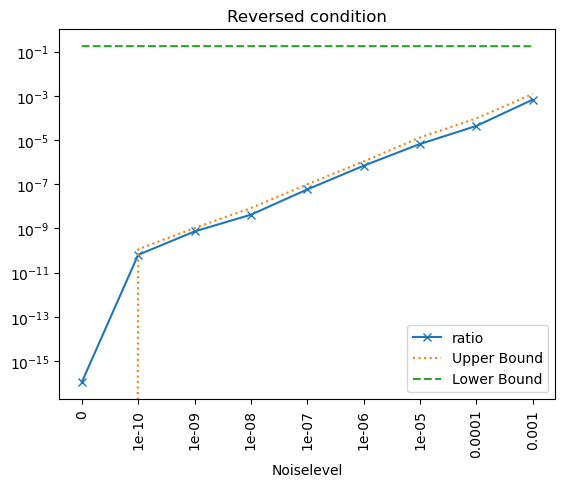

In [136]:
plt.title("Reversed condition")
plt.plot(ratios,marker='x',label="ratio")
#plt.plot(upper_bounds,':',label="Upper Bound")
plt.plot(lower_bounds,'--',label="Lower Bound")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()